In this notebook we'll look at the FAO trade data and look for some correlation with (geodesic) distance between countries. Spoiler alert: nope, not really any strong correlation. 

In [1]:
library(maptools)
library(spdep)
library(RColorBrewer)
library(fields)

Loading required package: sp
Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()
Loading required package: Matrix
Loading required package: spData
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`
Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following object is masked from ‘package:Matrix’:

    det

The following objects are masked from ‘package:base’

In [2]:
## Auxiliary functions
regulariseNames <- function(mat){
  Names <- gsub(" \\(Bolivarian Republic of\\)",
                "", gsub(" \\(Plurinational State of\\)", "", colnames(mat)) )
  colnames(mat) <- rownames(mat) <- Names
  return(mat)
}
#
plotTradeMatrix <- function(mat, transf = TRUE, title = ""){
  if(transf) mat <- log10(mat + 1)
  mat <- t(mat)[, ncol(mat):1]
  Names1 <- rownames(mat); K1 <- length(Names1)
  Names2 <- colnames(mat); K2 <- length(Names2)
  par(mar = c(5, 4.5, 4, 7))
  image(mat, col = tim.colors(100),
        xlab = "To", ylab = "From", main = title,
        axes = FALSE)
  mtext(text = rev(Names1), side = 2, line = 0.3, at = seq(0, 1, 1/(K1-1)), las = 1, cex = 0.8)
  mtext(text = rev(Names2), side = 1, line = 0.3, at = seq(0, 1, 1/(K2-1)), las = 2, cex = 0.8)
  image.plot(mat, col = tim.colors(100), legend.only = TRUE, legend.lab = "log Heads")
}

### Trade data 

In [3]:
load(file = "../../DATA/TRADE_DATA/tradeArray_Cattle.RData")
load(file = "../../DATA/TRADE_DATA/tradeArray_Goats.RData")
load(file = "../../DATA/TRADE_DATA/tradeArray_Pigs.RData")
load(file = "../../DATA/TRADE_DATA/tradeArray_Sheep.RData")
load(file = "../../DATA/TRADE_DATA/tradeArray_Horses.RData")

In [4]:
TotalCattle <- apply(Cattle, c(1, 2), sum)
TotalGoats <- apply(Goats, c(1, 2), sum)
TotalPigs <- apply(Pigs, c(1, 2), sum)
TotalSheep <- apply(Sheep, c(1, 2), sum)
TotalHorses <- apply(Horses, c(1, 2), sum)

Mcattle <- regulariseNames(TotalCattle)
Mgoats <- regulariseNames(TotalGoats)
Mpigs <- regulariseNames(TotalPigs)
Msheep <- regulariseNames(TotalSheep)
Mhorses <- regulariseNames(TotalHorses)

Now let's produce some matrix plots

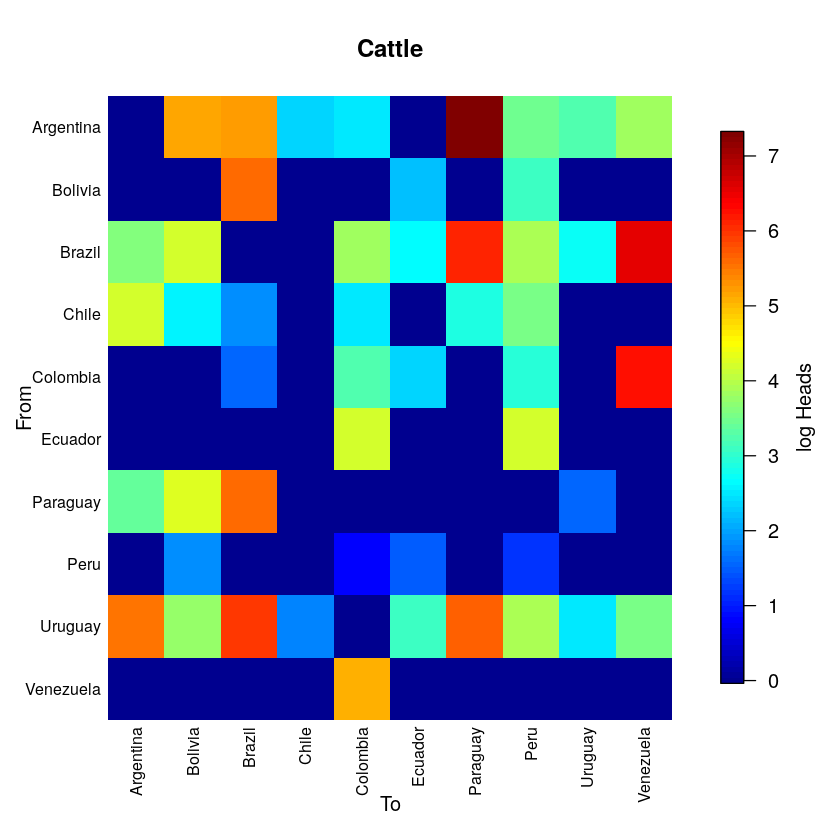

In [6]:
plotTradeMatrix(mat = Mcattle, title = "Cattle")

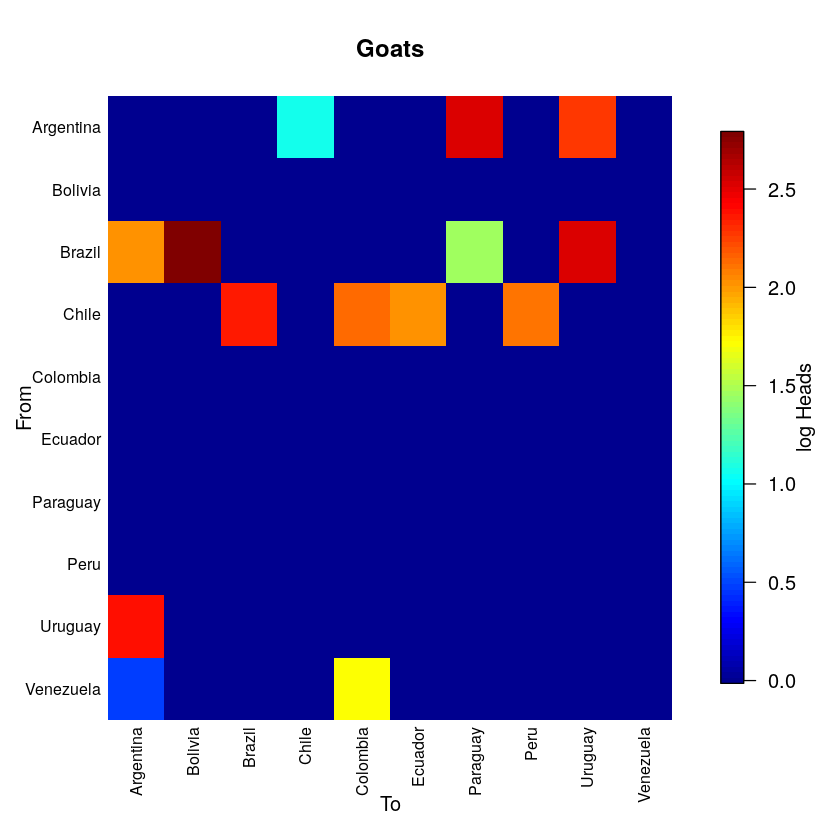

In [7]:
plotTradeMatrix(mat = Mgoats, title = "Goats")

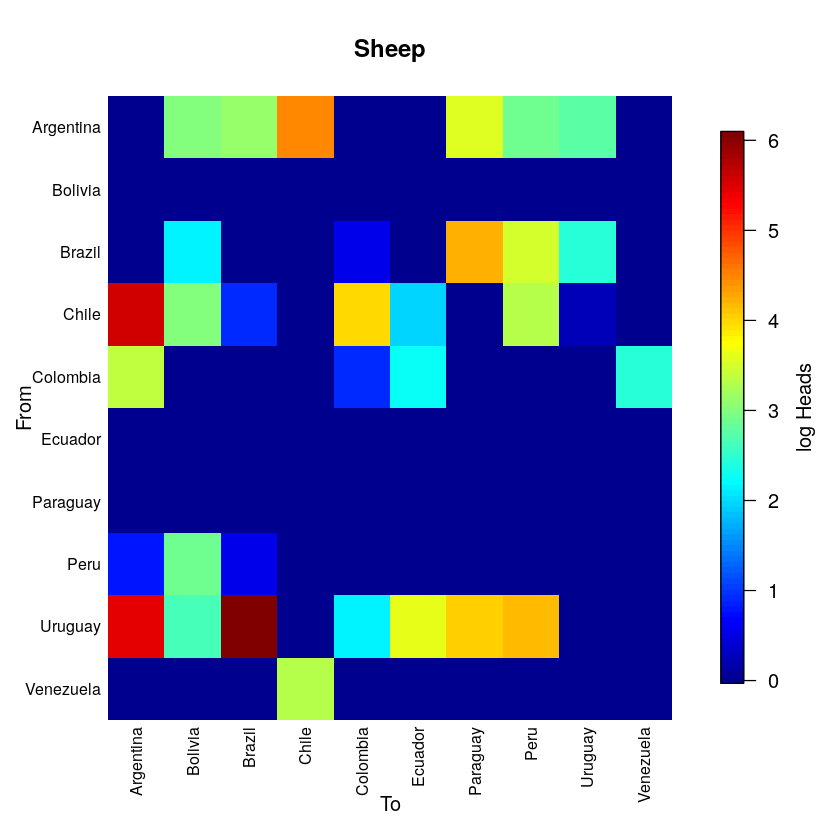

In [8]:
plotTradeMatrix(mat = Msheep, title = "Sheep")

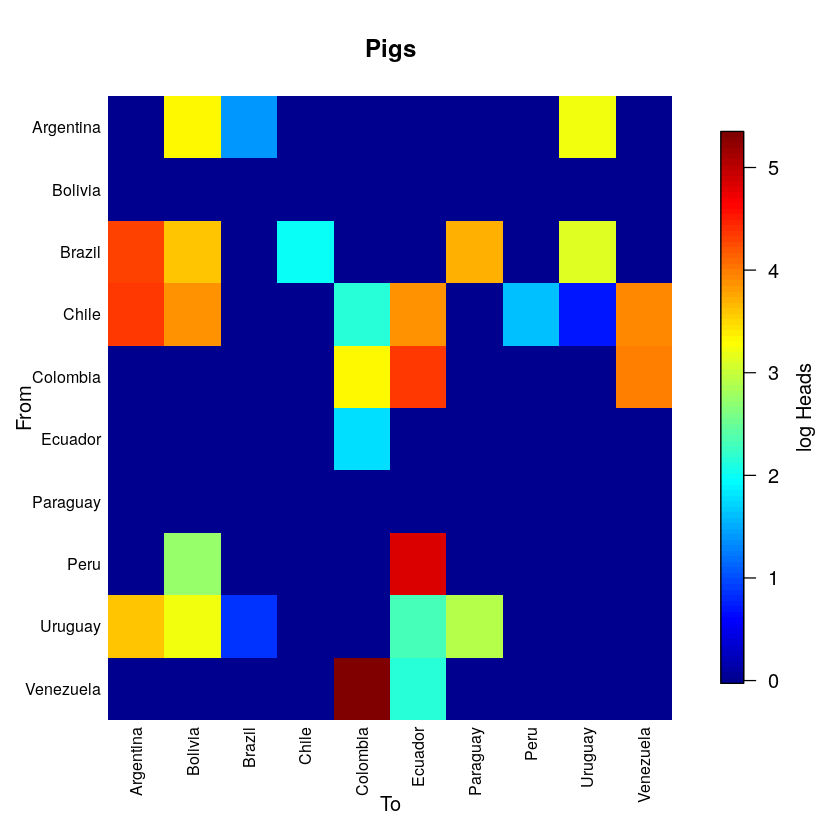

In [9]:
plotTradeMatrix(mat = Mpigs, title = "Pigs")

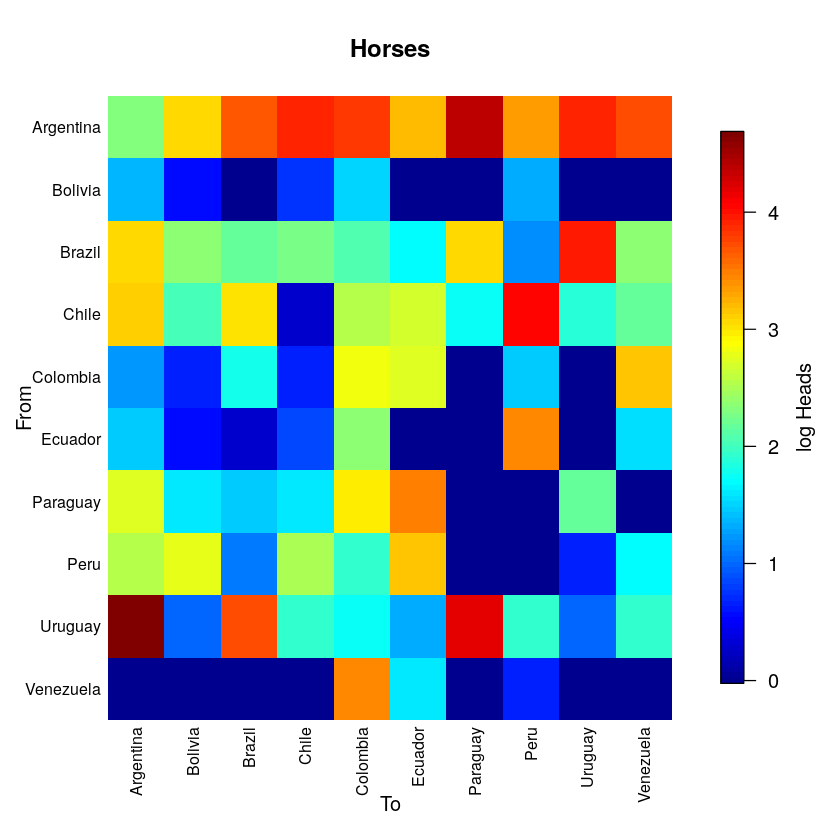

In [10]:
plotTradeMatrix(mat = Mhorses, title = "Horses")

### Distance stuff

In [11]:
Countries <- c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador",
                 "Paraguay", "Peru", "Uruguay", "Venezuela")  
data(wrld_simpl)
world <- wrld_simpl

which.polys <- vector(mode = "list", length(Countries))
for (c in 1:length(Countries)){
  which.polys[[c]] <- grep(paste(Countries[c]), world$NAME)
}
SA <- world[unlist(which.polys), ]

coordsSA <- coordinates(SA)

distmat <- rdist.earth(coordsSA, miles = FALSE)

### Preparing for plot

In [12]:
flux <- c(as.vector(Mcattle), as.vector(Msheep),
          as.vector(Mgoats), as.vector(Mpigs),  as.vector(Mhorses) )
livestock <- c(rep("Cattle", length(Countries)^2),
               rep("Sheep", length(Countries)^2),
               rep("Goats", length(Countries)^2),
               rep("Pigs", length(Countries)^2),
               rep("Horses", length(Countries)^2)
)
K <- length(Countries)
template_M <- matrix(NA, K, K)
type <- rep(NA, K^2)
uT <- which(upper.tri(template_M, diag = FALSE))
lT <- which(lower.tri(template_M, diag = FALSE))
dP <- setdiff(seq_len(K^2), c(uT, lT))
type[uT] <- "LowerTri"
type[dP] <- "Diag"
type [lT] <- "UpperTri"

plotData <- data.frame(distance = rep(as.vector(distmat), ncol(distmat)),
                      flux = flux,
                      livestock = livestock,
                      type = type)

In [18]:
options(repr.plot.width=10, repr.plot.height=5)

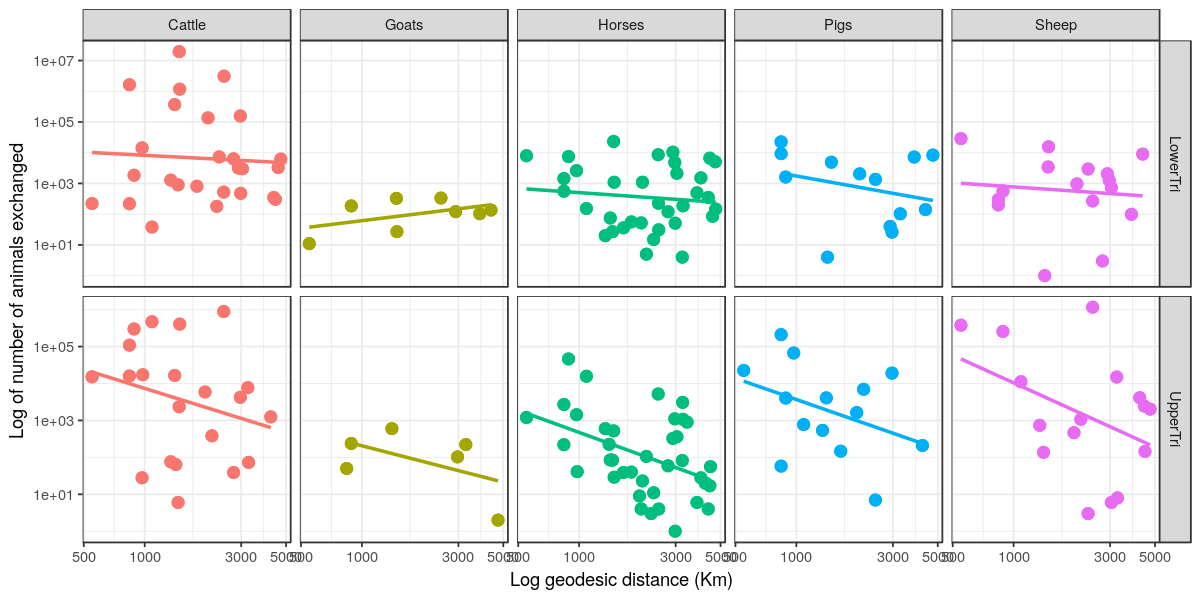

In [19]:
forplot <- subset(plotData, flux > 0 & type != "Diag")
library(ggplot2)
p <- qplot(distance, flux, data = forplot, colour = livestock, fill = livestock) 
q <- p +
  geom_point(size = 3) +
  geom_smooth(method = "gam", se = FALSE) +
  scale_y_log10("Log of number of animals exchanged") + 
  scale_x_log10("Log geodesic distance (Km)") +
  facet_grid(type~livestock, scales = "free_y") +
  guides(fill = FALSE, colour = FALSE) +
  theme_bw()
q